In [48]:
%pip install xgboost

import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, accuracy_score, f1_score
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.combine import SMOTETomek

le = LabelEncoder()
scaler = StandardScaler()

Note: you may need to restart the kernel to use updated packages.


# EDA & Preprocessing

In [49]:
df = pd.read_csv('./datasets/Student Lifestyle and Mental Health.csv')
df

,Student ID,Study Hours,Extracurricular Hours,Sleep Hours,Social Hours,Physical Activity Hours,Stress Level,Gender,Grades
0,1,6.9,3.8,8.7,2.8,1.8,Moderate,Male,7.48
1,2,5.3,3.5,8.0,4.2,3.0,Low,Female,6.88
2,3,5.1,3.9,9.2,1.2,4.6,Low,Male,6.68
3,4,6.5,2.1,7.2,1.7,6.5,Moderate,Male,7.20
4,5,8.1,0.6,6.5,2.2,6.6,High,Male,8.78
...,...,...,...,...,...,...,...,...,...
1995,1996,6.5,0.2,7.4,2.1,7.8,Moderate,Male,8.30
1996,1997,6.3,2.8,8.8,1.5,4.6,Moderate,Female,6.62
1997,1998,6.2,0.0,6.2,0.8,10.8,Moderate,Male,7.85
1998,1999,8.1,0.7,7.6,3.5,4.1,High,Male,7.60


In [50]:
temp_columns = []
for column in df.columns: 
	temp_columns.append(column.replace(" ", "_"))
	
df.columns = temp_columns

![WhatsApp Image 2025-05-27 at 17.56.03_a8493fdb.jpg](<attachment:WhatsApp Image 2025-05-27 at 17.56.03_a8493fdb.jpg>)
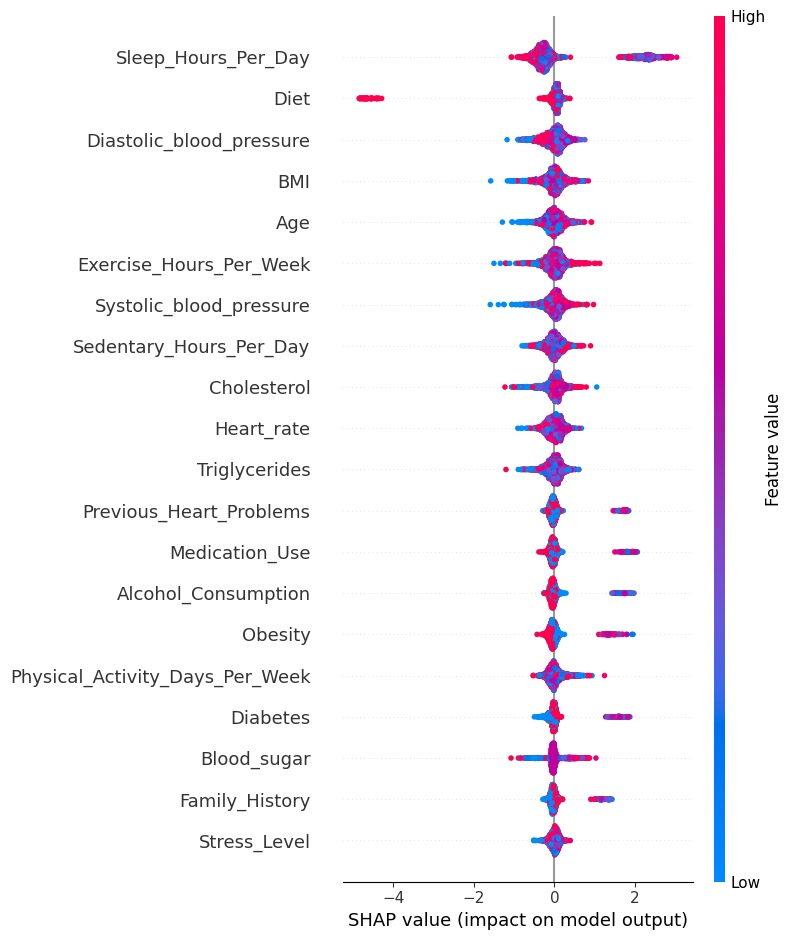

In [51]:
df = df.drop(columns=['CK-MB', 'Troponin', 'Heart_Attack_Risk_Text', 'Income', 'Stress_Level', 'Family_History', 'Blood_sugar', 'Diabetes', 
                      'Physical_Activity_Days_Per_Week', 'Obesity', 'Alcohol_Consumption', 'Medication_Use',
                      'Smoking', 'Triglycerides', 'Previous_Heart_Problems'], errors='ignore') # membuang fitur yang tidak ingin digunakan untuk mengurangi feature dengan SHAP
df

,Student_ID,Study_Hours,Extracurricular_Hours,Sleep_Hours,Social_Hours,Physical_Activity_Hours,Gender,Grades
0,1,6.9,3.8,8.7,2.8,1.8,Male,7.48
1,2,5.3,3.5,8.0,4.2,3.0,Female,6.88
2,3,5.1,3.9,9.2,1.2,4.6,Male,6.68
3,4,6.5,2.1,7.2,1.7,6.5,Male,7.20
4,5,8.1,0.6,6.5,2.2,6.6,Male,8.78
...,...,...,...,...,...,...,...,...
1995,1996,6.5,0.2,7.4,2.1,7.8,Male,8.30
1996,1997,6.3,2.8,8.8,1.5,4.6,Female,6.62
1997,1998,6.2,0.0,6.2,0.8,10.8,Male,7.85
1998,1999,8.1,0.7,7.6,3.5,4.1,Male,7.60


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Student_ID               2000 non-null   int64  
 1   Study_Hours              2000 non-null   float64
 2   Extracurricular_Hours    2000 non-null   float64
 3   Sleep_Hours              2000 non-null   float64
 4   Social_Hours             2000 non-null   float64
 5   Physical_Activity_Hours  2000 non-null   float64
 6   Gender                   2000 non-null   object 
 7   Grades                   2000 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 125.1+ KB


In [53]:
df.describe(include=['object'])

,Gender
count,2000
unique,2
top,Male
freq,1016


In [54]:
df.describe(include=['number'])

,Student_ID,Study_Hours,Extracurricular_Hours,Sleep_Hours,Social_Hours,Physical_Activity_Hours,Grades
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000
mean,1000.500000,7.475800,1.990100,7.501250,2.704550,4.32830,7.789825
std,577.494589,1.423888,1.155855,1.460949,1.688514,2.51411,0.746777
min,1.000000,5.000000,0.000000,5.000000,0.000000,0.00000,5.600000
25%,500.750000,6.300000,1.000000,6.200000,1.200000,2.40000,7.250000
50%,1000.500000,7.400000,2.000000,7.500000,2.600000,4.10000,7.780000
75%,1500.250000,8.700000,3.000000,8.800000,4.100000,6.10000,8.320000
max,2000.000000,10.000000,4.000000,10.000000,6.000000,13.00000,10.000000


In [55]:
df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

In [56]:
df.isna().sum()[df.isna().sum() > 0]/ df.shape[0] *100 # cek seberapa persen data yang kosong

Series([], dtype: float64)

In [57]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else: 
        df[col] = df[col].fillna(df[col].median())

In [58]:
print('Duplicated value:', df.duplicated().sum())

Duplicated value: 0


In [59]:
df = df.drop_duplicates()

In [60]:
print('Duplicated value:', df.duplicated().sum())

Duplicated value: 0


In [61]:
df_eda = df.copy()

In [62]:
numerical = df_eda.select_dtypes(include=['number'])
categorical = df_eda.select_dtypes(include=['object'])

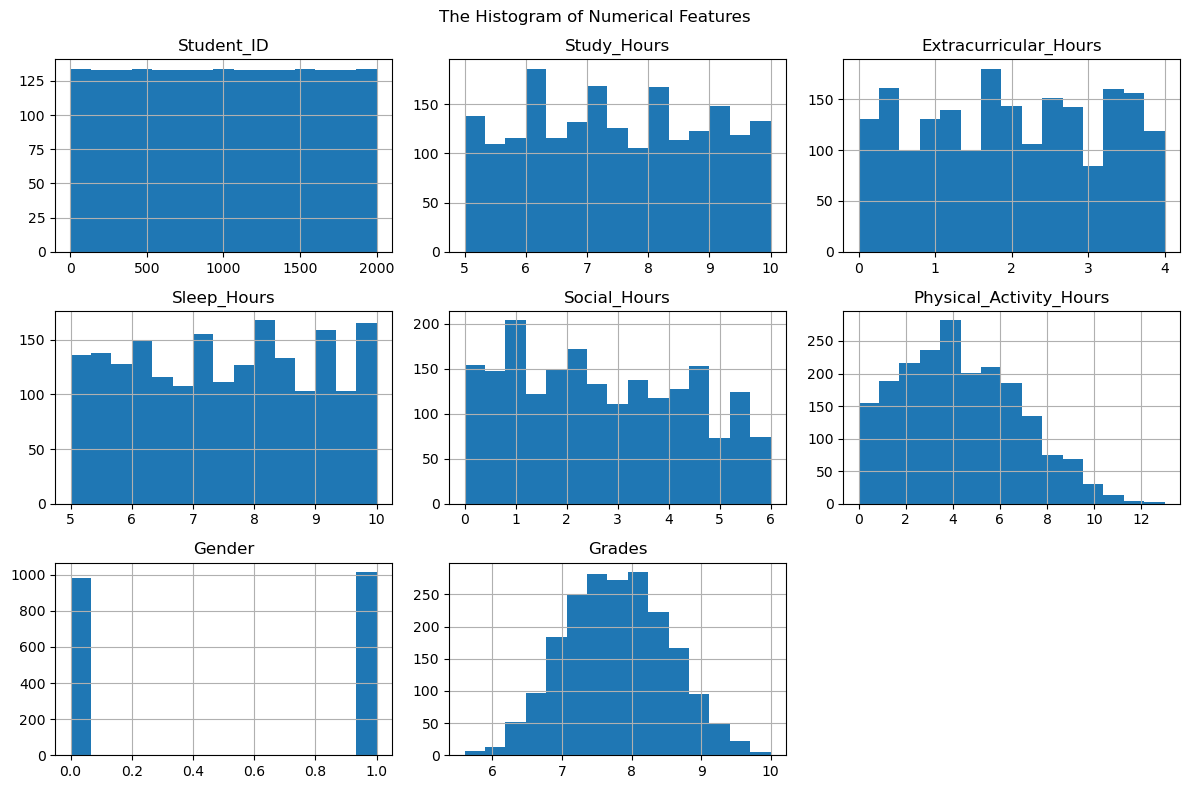

In [63]:
numerical.hist(bins=15, figsize=(12, 8))
plt.suptitle('The Histogram of Numerical Features')
plt.tight_layout()
plt.show()

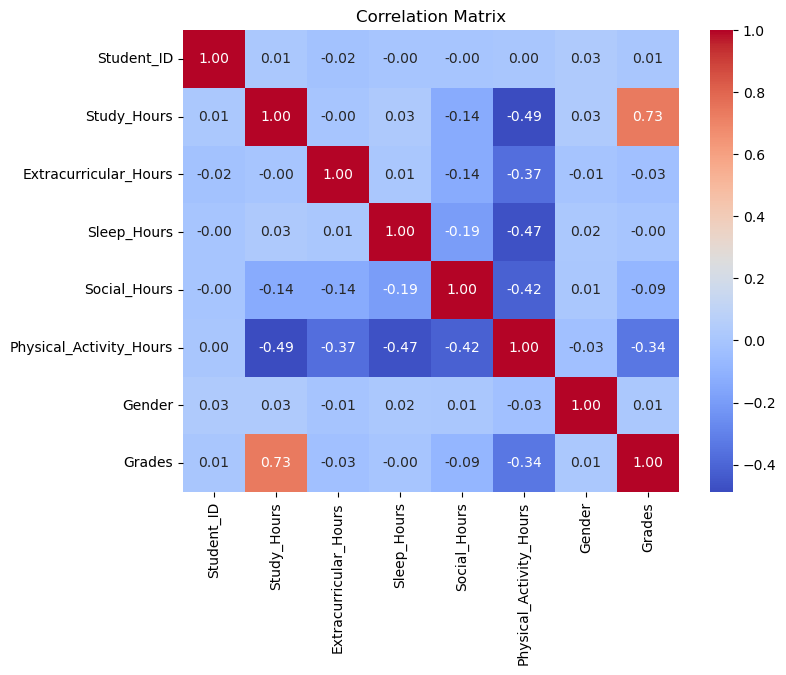

In [64]:
# correlation matrix antara semua feature
plt.figure(figsize=(8, 6))
corr_matrix = df_eda.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

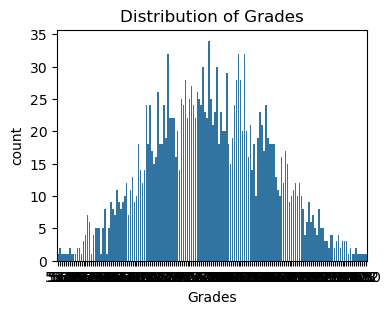

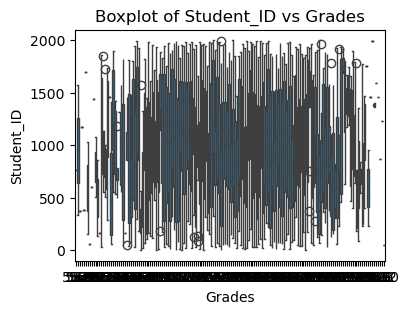

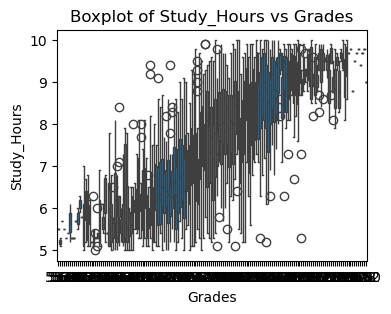

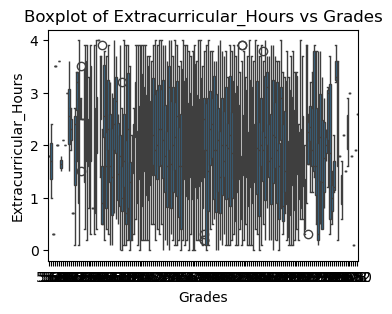

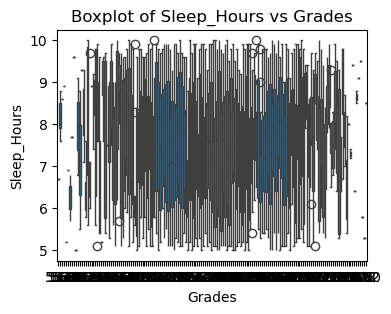

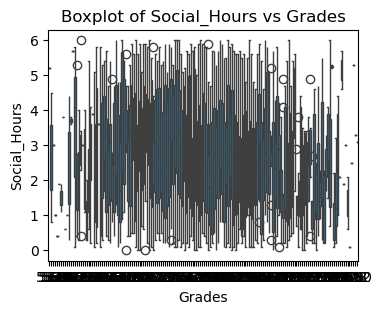

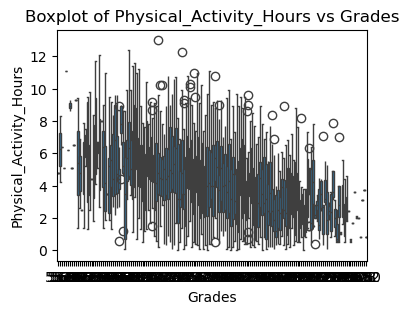

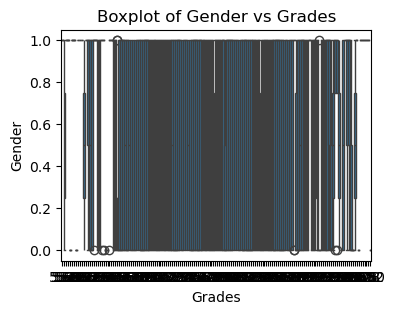

In [65]:
plt.figure(figsize=(4, 3))
sns.countplot(data=df_eda, x='Grades')
plt.title('Distribution of Grades')
plt.show()

for col in df_eda.columns:
    if col != 'Grades':
        plt.figure(figsize=(4, 3))
        sns.boxplot(x='Grades', y=col, data=df_eda)
        plt.title(f'Boxplot of {col} vs Grades')
        plt.show()

# Training

In [66]:
x = df.drop(columns=['Grades'])
y = df['Grades']

In [67]:
st = SMOTETomek(random_state=42)
x_sampled, y_sampled = st.fit_resample(x, y)

ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_sampled, y_sampled, test_size=0.2, stratify=y_sampled)

In [ ]:
train_cat = x_train.select_dtypes(include=['object'])
for col in train_cat:
    x_train[col] = le.fit_transform(x_train[col])
    x_test[col] = le.transform(x_test[col])

In [ ]:
df = pd.concat([x_train, y_train], axis=1)
df

,Age,Cholesterol,Heart_rate,Exercise_Hours_Per_Week,Diet,Sedentary_Hours_Per_Day,BMI,Sleep_Hours_Per_Day,Gender,Systolic_blood_pressure,Diastolic_blood_pressure,Heart_Attack_Risk
10475,0.426051,0.028230,0.043335,0.539844,0,0.305427,0.671640,0.666667,0,0.712795,0.534720,1.0
7637,0.213483,0.432143,0.046746,0.943637,2,0.405339,0.325359,0.500000,0,0.432258,0.732558,0.0
10528,0.698192,0.721429,0.043042,0.210746,0,0.740337,0.172369,0.468212,0,0.655903,0.442939,1.0
2744,0.202247,0.689286,0.051329,0.635065,2,0.779947,0.783634,0.666667,1,0.516129,0.232558,0.0
319,0.224719,0.446429,0.061412,0.759494,1,0.977993,0.904287,0.333333,0,0.329032,0.697674,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3061,0.730337,0.707143,0.077910,0.097415,1,0.701239,0.084173,0.500000,1,0.309677,0.232558,1.0
3599,0.561798,0.800000,0.045830,0.458315,0,0.679010,0.168214,1.000000,1,0.651613,0.465116,0.0
234,0.191011,0.914286,0.078827,0.063365,1,0.685787,0.766357,0.833333,1,0.625806,0.430233,0.0
4410,0.078652,0.600000,0.060495,0.859176,0,0.821637,0.449500,0.000000,1,0.380645,0.790698,0.0


In [ ]:
# menghilangkan outlier dengan IQR

for col in df.columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    atas = q3 + 1.5*iqr
    bawah = q1 - 1.5*iqr
    df_clean = df[(df[col] >= bawah) & (df[col] <= atas)]

x_train = df.drop(columns=['Heart_Attack_Risk'])
y_train = df['Heart_Attack_Risk']

In [ ]:
normalized = ['Cholesterol', 'Heart_rate', 'Stress_Level', 'BMI', 'Triglycerides', 'Blood_sugar', 'Systolic_blood_pressure', 'Diastolic_blood_pressure'] 
# fitur ini sudah di normalisasi dari datasetnya

for col in x_train.columns:
    if col not in normalized:
        x_train[[col]] = scaler.fit_transform(x_train[[col]])
        x_test[[col]] = scaler.transform(x_test[[col]])

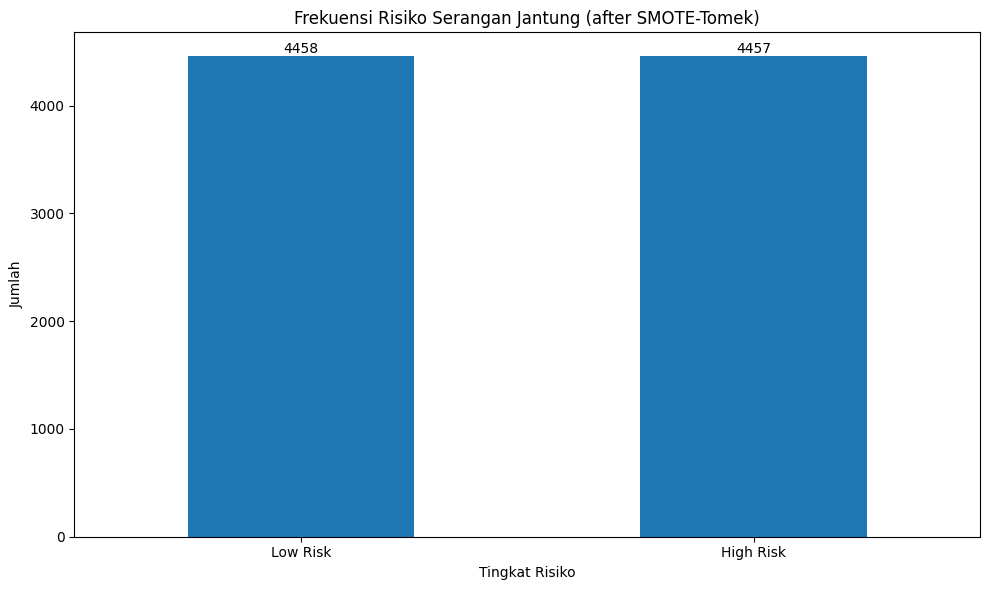

In [ ]:
target = y_train.value_counts()

classes = ['Low Risk', 'High Risk']
plt.figure(figsize=(10, 6))
target.plot(kind='bar')
plt.title('Frekuensi Risiko Serangan Jantung (after SMOTE-Tomek)')
plt.xlabel('Tingkat Risiko')
plt.ylabel('Jumlah')
plt.xticks(ticks=[0, 1], labels=classes, rotation=0)

for i, v in enumerate(target):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Random Forest

In [ ]:
rfc = RandomForestClassifier()
param_grid_rf = {
    'n_estimators': [850, 900, 950], 
    'max_depth': [6, 8, 10],  
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],  
    'max_samples': [0.9, 1.0],  
    'max_features': [0.9, 1.0] 
}
# grid_search_rf = GridSearchCV(rfc, param_grid_rf, scoring='accuracy', cv=5, refit="f1", n_jobs=-1)
rfc.fit(x_train, y_train)

RandomForestClassifier()

Accuracy:  0.7438313144908031
Recall:  0.718132854578097
Precision:  0.7568590350047304
F1: 0.7369875633348687
              precision    recall  f1-score   support

         0.0       0.73      0.77      0.75      1115
         1.0       0.76      0.72      0.74      1114

    accuracy                           0.74      2229
   macro avg       0.74      0.74      0.74      2229
weighted avg       0.74      0.74      0.74      2229

[[858 257]
 [314 800]]


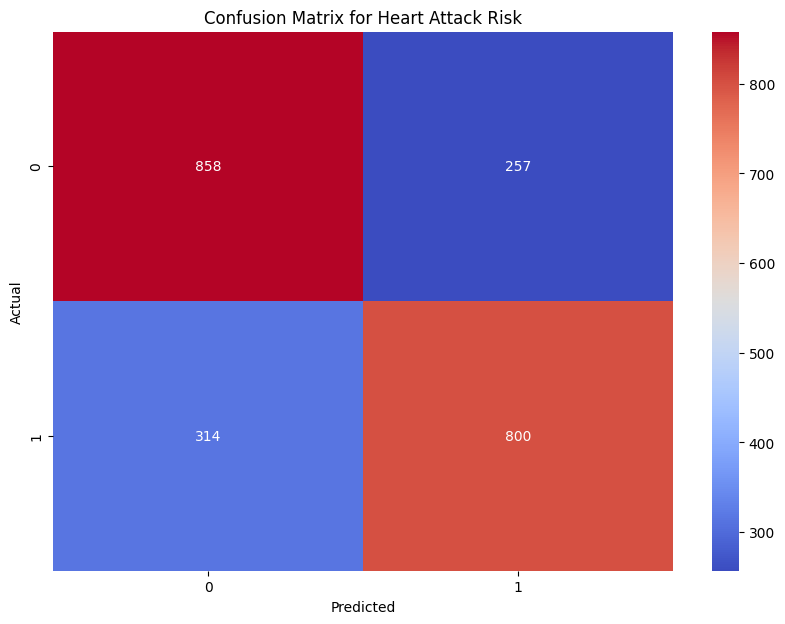

In [ ]:
# best_model_xgb = grid_search_xgb.best_estimator_
y_pred = rfc.predict(x_test)
accuracy_rf = accuracy_score(y_test, y_pred)
f1_rf = f1_score(y_test, y_pred)
prec_rf = precision_score(y_test, y_pred)
rec_rf = recall_score(y_test, y_pred)
print('Accuracy: ', accuracy_rf)
print('Recall: ', rec_rf)
print('Precision: ', prec_rf)
print('F1:', f1_rf)
print(classification_report(y_test, y_pred))

classes = ['Low', 'High']
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(suppress=True, precision=1)
print(cm)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Heart Attack Risk')
plt.show()

## XGBoost

In [ ]:
param_grid_xgb = {
        'n_estimators': [700, 750, 800],
        'max_depth': [12, 14, 16],
        'learning_rate': [0.03, 0.04, 0.05],
        'subsample': [0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8]
}

xgbm = XGBClassifier(eval_metric="mlogloss")
# grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')
xgbm.fit(x_train, y_train)
# print("Best parameters found: ", grid_search_xgb.best_params_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

Accuracy:  0.6850605652759085
Recall:  0.6481149012567325
Precision:  0.6996124031007752
F1: 0.6728797763280522
              precision    recall  f1-score   support

         0.0       0.67      0.72      0.70      1115
         1.0       0.70      0.65      0.67      1114

    accuracy                           0.69      2229
   macro avg       0.69      0.69      0.68      2229
weighted avg       0.69      0.69      0.68      2229

[[805 310]
 [392 722]]


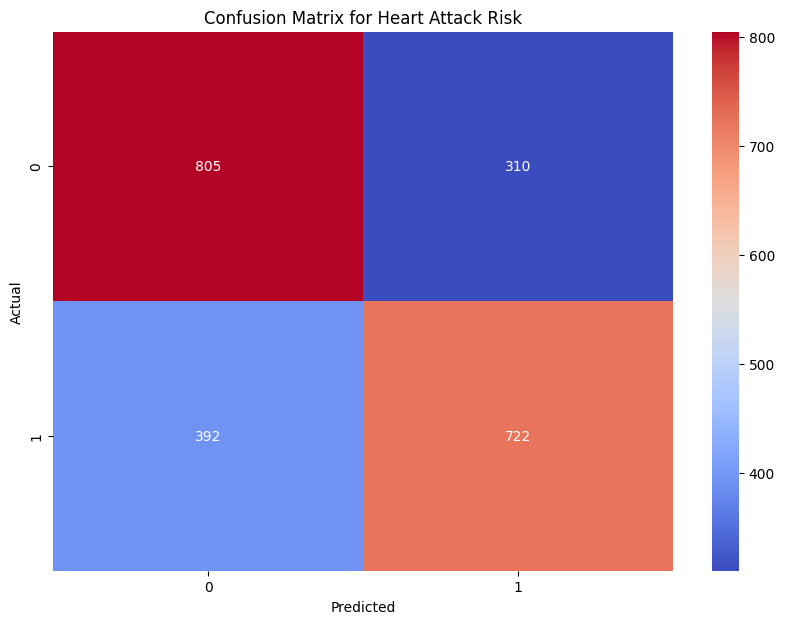

In [ ]:
# best_model_xgb = grid_search_xgb.best_estimator_
y_pred = xgbm.predict(x_test)
accuracy_xgb = accuracy_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred)
prec_xgb = precision_score(y_test, y_pred)
rec_xgb = recall_score(y_test, y_pred)
print('Accuracy: ', accuracy_xgb)
print('Recall: ', rec_xgb)
print('Precision: ', prec_xgb)
print('F1:', f1_xgb)
print(classification_report(y_test, y_pred))

classes = ['Low', 'High']
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(suppress=True, precision=1)
print(cm)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Heart Attack Risk')
plt.show()

## KNN

In [ ]:
knn = KNeighborsClassifier()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
param_grid_knn = {
    'n_neighbors': [9, 10, 11],
    'weights': ['distance', 'uniform'],
    'metric': ['manhattan', 'euclidean', 'minkowski'],
    'leaf_size': [16, 18, 20, 22, 24], 
    'p': [1, 2]
}

# grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=kf, n_jobs=-1, verbose=1, scoring='accuracy')
knn.fit(x_train, y_train)
# best_model_knn = knn.best_estimator_
# params = knn.best_params_
# print(params)

KNeighborsClassifier()

Accuracy:  0.6536563481381785
Precision:  0.6293494704992436
Recall:  0.7468581687612208
F1: 0.6830870279146142
              precision    recall  f1-score   support

         0.0       0.69      0.56      0.62      1115
         1.0       0.63      0.75      0.68      1114

    accuracy                           0.65      2229
   macro avg       0.66      0.65      0.65      2229
weighted avg       0.66      0.65      0.65      2229

[[625 490]
 [282 832]]


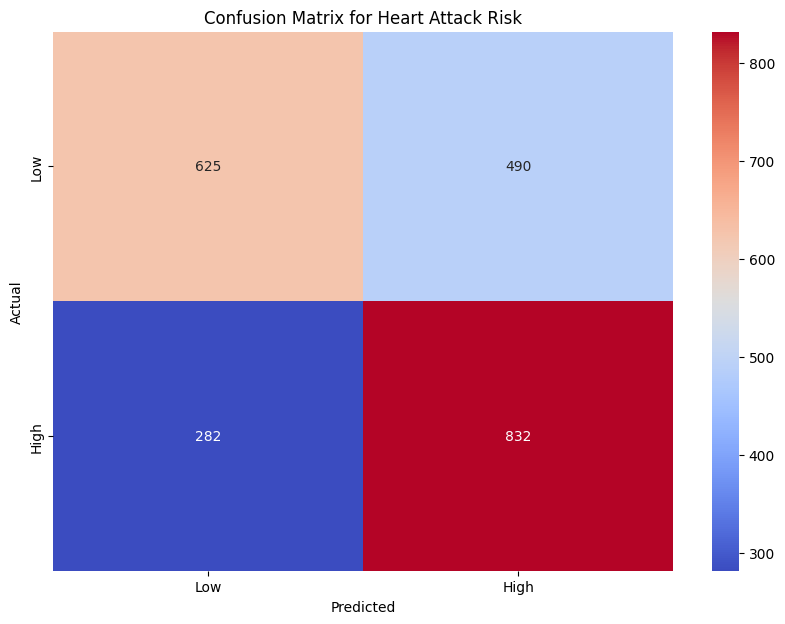

In [ ]:
y_pred = knn.predict(x_test)
accuracy_knn = accuracy_score(y_test, y_pred)
f1_knn = f1_score(y_test, y_pred)
prec_knn = precision_score(y_test, y_pred)
rec_knn = recall_score(y_test, y_pred)
print('Accuracy: ', accuracy_knn)
print('Precision: ', prec_knn)
print('Recall: ', rec_knn)
print('F1:', f1_knn)
print(classification_report(y_test, y_pred))

classes = ['Low', 'High']
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='coolwarm', xticklabels=classes, yticklabels=classes, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Heart Attack Risk')
plt.show()

# Perbandingan Ketiga Model

In [ ]:
with open("best_model_knn.pkl", "rb") as f:
    knn, accuracy_knn, prec_knn, rec_knn, f1_knn = pickle.load(f)

with open("best_model_xgb.pkl", "rb") as f:
    xgbm, accuracy_xgb, prec_xgb, rec_xgb, f1_xgb = pickle.load(f)

with open("best_model_rf.pkl", "rb") as f:
    rfc, accuracy_rf, prec_rf, rec_rf, f1_rf = pickle.load(f)

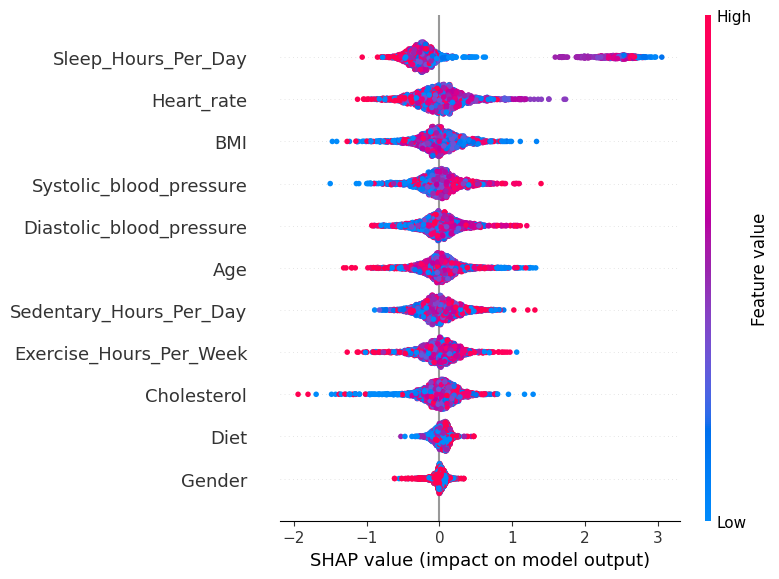

In [ ]:
import shap
import xgboost as xgb
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(xgbm)
shap_values = explainer.shap_values(x_test)

shap.summary_plot(shap_values, x_test)

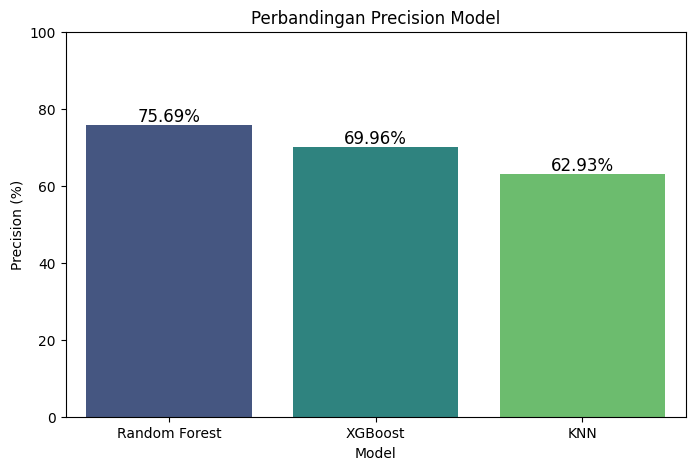

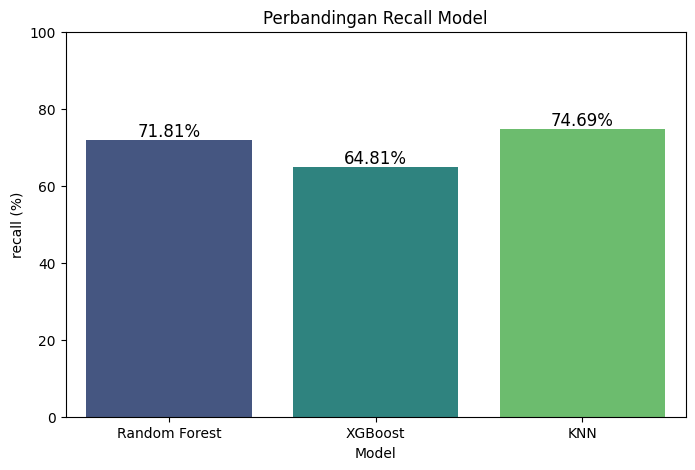

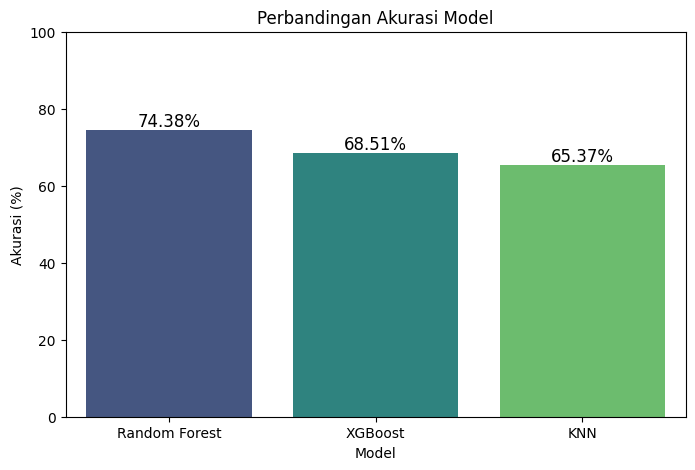

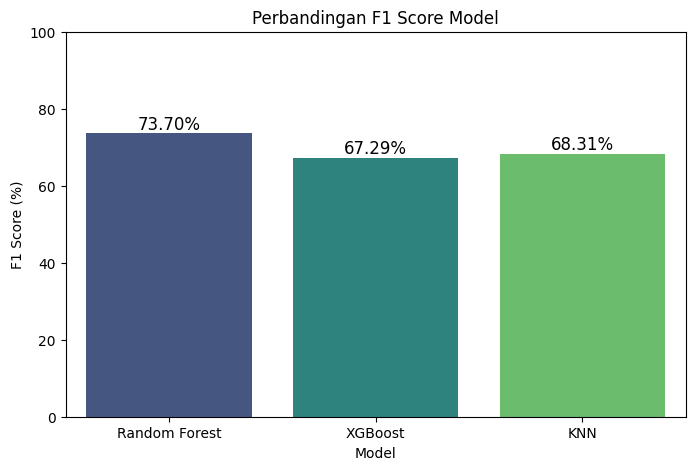

In [ ]:
models = ['Random Forest', 'XGBoost', 'KNN']
precisions = [prec_rf*100, prec_xgb*100, prec_knn*100]  # dalam persen (%)
recalls = [rec_rf*100, rec_xgb*100, rec_knn*100]  # dalam persen (%)
accuracies = [accuracy_rf*100, accuracy_xgb*100, accuracy_knn*100]  # dalam persen (%)
f1_scores = [f1_rf*100, f1_xgb*100, f1_knn*100]  # dalam persen (%)

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=precisions, palette='viridis', hue=models, legend=False)

plt.ylim(0, 100)
plt.ylabel("Precision (%)")
plt.xlabel("Model")
plt.title("Perbandingan Precision Model")

for i, acc in enumerate(precisions):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center', fontsize=12)

plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=recalls, palette='viridis', hue=models, legend=False)
plt.ylim(0, 100)
plt.ylabel("recall (%)")
plt.xlabel("Model")
plt.title("Perbandingan Recall Model")

for i, f1 in enumerate(recalls):
    plt.text(i, f1 + 1, f"{f1:.2f}%", ha='center', fontsize=12)

plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracies, palette='viridis', hue=models, legend=False)

plt.ylim(0, 100)
plt.ylabel("Akurasi (%)")
plt.xlabel("Model")
plt.title("Perbandingan Akurasi Model")

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center', fontsize=12)

plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=f1_scores, palette='viridis', hue=models, legend=False)

plt.ylim(0, 100)
plt.ylabel("F1 Score (%)")
plt.xlabel("Model")
plt.title("Perbandingan F1 Score Model")

for i, acc in enumerate(f1_scores):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center', fontsize=12)

plt.show()

Dikarenakan KNN memiliki recall tertinggi di antara ketiganya, maka KNN akan dipilih sebagai model yang digunakan dalam Heart Attack Risk Prediction ini, dikarenakan recall hanya mengambil proporsi antara True Positive dengan False Negative, sehingga ketika recall semakin besar, maka semakin besar pula nilai True Positivenya dengan nilai False Negative yang lebih sedikit.

In [ ]:
feature_names = df.drop(columns=['Heart_Attack_Risk']).columns
print("Fitur yang digunakan dan diinput ke dalam model:\n", feature_names)

Fitur yang digunakan dan diinput ke dalam model:
 Index(['Age', 'Cholesterol', 'Heart_rate', 'Exercise_Hours_Per_Week', 'Diet',
       'Sedentary_Hours_Per_Day', 'BMI', 'Sleep_Hours_Per_Day', 'Gender',
       'Systolic_blood_pressure', 'Diastolic_blood_pressure'],
      dtype='object')


In [ ]:
# INPUT UNTUK RESIKO SERANGAN JANTUNG TINGGI untuk KNN
# Age = 65
# Gender = 1  # Laki-laki
# Cholesterol = 300.0
# Heart_rate = 100.0
# Exercise_Hours_Per_Week = 1
# Diet = 1
# Sedentary_Hours_Per_Day = 12.0
# berat: 120
# tinggi: 120
# Sleep_Hours_Per_Day = 4.0
# Systolic_blood_pressure = 179.0
# Diastolic_blood_pressure = 120.0

# INPUT UNTUK RESIKO SERANGAN JANTUNG RENDAH untuk KNN
# Age = 25
# Gender = 0  # Perempuan
# Cholesterol = 150.0
# Heart_rate = 60.0
# Exercise_Hours_Per_Week = 7.0
# Diet = 3
# Sedentary_Hours_Per_Day = 1.0
# berat: 50
# tinggi: 160
# Sleep_Hours_Per_Day = 8.0
# Systolic_blood_pressure = 110.0
# Diastolic_blood_pressure = 70.0

In [ ]:
Age = int(input("Masukkan umur: "))
Gender = 1 if input("Masukkan jenis kelamin (Laki-laki/Perempuan): ").strip().lower() == "laki-laki" else 0
Cholesterol = float(input("Masukkan tingkat kolesterol (mg/dL): "))
Heart_rate = float(input("Masukkan denyut jantung saat istirahat (bpm): "))
Exercise_Hours_Per_Week = float(input("Masukkan jumlah jam berolahraga per minggu: "))
Diet = int(input("Masukkan kategori diet (1 = buruk, 5 = sangat baik): "))
Sedentary_Hours_Per_Day = float(input("Masukkan jumlah jam tidak aktif per hari: "))
b_badan = int(input('Masukkan berat badan (kg): '))
t_badan = int(input('Masukkan tinggi badan (cm): '))
BMI = b_badan/(t_badan/100*t_badan/100)
Sleep_Hours_Per_Day = float(input("Masukkan jumlah jam tidur per hari: "))
Systolic_blood_pressure = float(input("Masukkan tekanan darah sistolik (mmHg): "))
Diastolic_blood_pressure = float(input("Masukkan tekanan darah diastolik (mmHg): "))

user_data = np.array([[Age, Gender, Cholesterol, Heart_rate, Exercise_Hours_Per_Week, Diet,
                       Sedentary_Hours_Per_Day, BMI, Sleep_Hours_Per_Day, 
                       Systolic_blood_pressure, Diastolic_blood_pressure]])

prediction_knn = knn.predict(user_data)
prediction_xgb = xgbm.predict(user_data)
prediction_rf = rfc.predict(user_data)

c:\Users\Mercury\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\Mercury\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## Hasil menggunakan Random Forest

In [ ]:
hasil = ''
if prediction_rf[0] == 0:
    hasil = 'Rendah'
elif prediction_rf[0] == 1:
    hasil = 'Tinggi'
print(f"Hasil prediksi risiko serangan jantung: {hasil}")
print(f"Recall model: {rec_rf * 100:.2f}%")

Hasil prediksi risiko serangan jantung: Rendah
Recall model: 71.81%


## Hasil menggunakan XGBoost

In [ ]:
hasil = ''
if prediction_xgb[0] == 0:
    hasil = 'Rendah'
elif prediction_xgb[0] == 1:
    hasil = 'Tinggi'
print(f"Hasil prediksi risiko serangan jantung: {hasil}")
print(f"Recall model: {rec_xgb* 100:.2f}%")

Hasil prediksi risiko serangan jantung: Rendah
Recall model: 64.81%


## Hasil menggunakan K-Nearest Neighbor

In [ ]:
hasil = ''
if prediction_knn[0] == 0:
    hasil = 'Rendah'
elif prediction_knn[0] == 1:
    hasil = 'Tinggi'
print(f"Hasil prediksi risiko serangan jantung: {hasil}")
print(f"Recall model: {rec_knn * 100:.2f}%") 

Hasil prediksi risiko serangan jantung: Rendah
Recall model: 74.69%
